In [2]:
# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as signal
import pywt  # wavelet
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [6]:

# Cargar datos
chla = pd.read_excel('../data/Base de datos Chla consultoria estadística.xlsx')
tsm = pd.read_excel('../data/Base de datos TSM consultoria estadística.xlsx')
coordenadas = pd.read_csv('../data/Coordenadas zona costera occidental GC.csv')

In [9]:
print(chla.columns)
print(tsm.columns)


Index(['ORDEN', 'FECHA', 'AÑO', 'MES', 'ESTACIÓN DEL AÑO', 'EVENTO INTERANUAL',
       'Est 1°', 'Est 2°', 'Est 3°', 'Est 4°', 'Est 5°', 'Est 6°', 'Est 7° ',
       'Est 8° ', 'Est 9°', 'Est 10°', 'Est 11°', 'Est 12°', 'Est 13°',
       'Est 14°', 'Est 15°', 'Est 16°', 'Est 17°'],
      dtype='object')
Index(['ORDEN', 'FECHA', 'AÑO', 'MES', 'ESTACIÓN DEL AÑO', 'EVENTO INTERANUAL',
       'Est 1°', 'Est 2°', 'Est 3°', 'Est 4°', 'Est 5°', 'Est 6°', 'Est 7° ',
       'Est 8° ', 'Est 9°', 'Est 10°', 'Est 11°', 'Est 12°', 'Est 13°',
       'Est 14°', 'Est 15°', 'Est 16°', 'Est 17°'],
      dtype='object')


In [10]:
# fechas a datetime
chla['FECHA'] = pd.to_datetime(chla['FECHA'])
tsm['FECHA'] = pd.to_datetime(tsm['FECHA'])

# Vis rápida
print(chla.head())
print(tsm.head())

   ORDEN      FECHA   AÑO         MES ESTACIÓN DEL AÑO EVENTO INTERANUAL  \
0      1 1997-09-01  1997  Septiembre            Otoño              Niño   
1      2 1997-10-01  1997     Octubre            Otoño              Niño   
2      3 1997-11-01  1997   Noviembre            Otoño              Niño   
3      4 1997-12-01  1997   Diciembre         Invierno              Niño   
4      5 1998-01-01  1998       Enero         Invierno              Niño   

   Est 1°  Est 2°  Est 3°  Est 4°  ...  Est 8°   Est 9°  Est 10°  Est 11°  \
0  0.1351  0.1281  0.1808  0.2266  ...   0.5426  0.7643   1.0835   1.0230   
1  0.1281  0.1580  0.2165  0.2528  ...   0.4720  0.4914   0.6826   0.8687   
2  0.2229  0.2907  0.3404  0.3641  ...   0.7847  1.2401   1.2862   1.5959   
3  0.4121  0.3930  0.6597  0.7563  ...   0.5972  0.6240   0.7224   0.7215   
4  0.4254  0.5376  0.7848  0.6495  ...   1.0542  1.1530   0.9157   0.7955   

   Est 12°  Est 13°  Est 14°  Est 15°  Est 16°  Est 17°  
0   1.2773   1.4592   

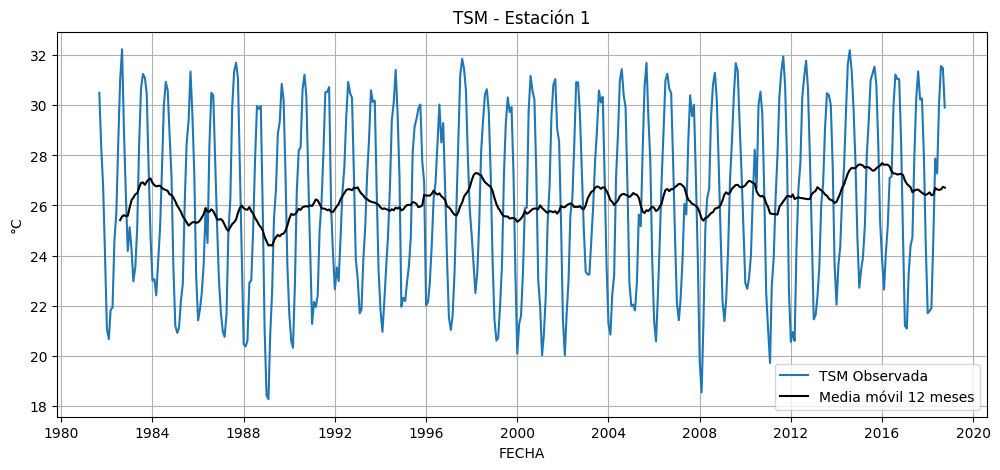

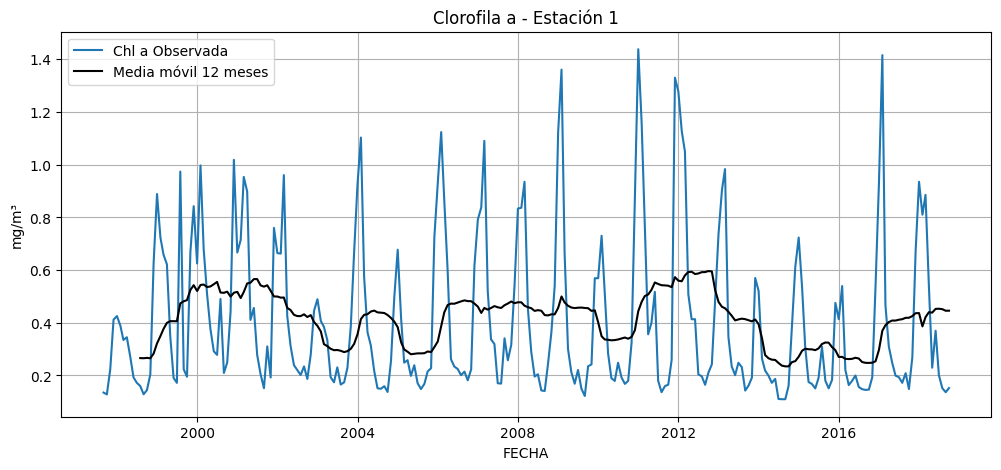

In [13]:
# Ejemplo para una estación: Estación 1
estacion = 'Est 1°'

# TSM
plt.figure(figsize=(12,5))
plt.plot(tsm['FECHA'], tsm[estacion], label='TSM Observada')
plt.plot(tsm['FECHA'], tsm[estacion].rolling(12).mean(), label='Media móvil 12 meses', color='black')
plt.title('TSM - Estación 1')
plt.xlabel('FECHA')
plt.ylabel('°C')
plt.legend()
plt.grid()
plt.show()

# Chl a
plt.figure(figsize=(12,5))
plt.plot(chla['FECHA'], chla[estacion], label='Chl a Observada')
plt.plot(chla['FECHA'], chla[estacion].rolling(12).mean(), label='Media móvil 12 meses', color='black')
plt.title('Clorofila a - Estación 1')
plt.xlabel('FECHA')
plt.ylabel('mg/m³')
plt.legend()
plt.grid()
plt.show()

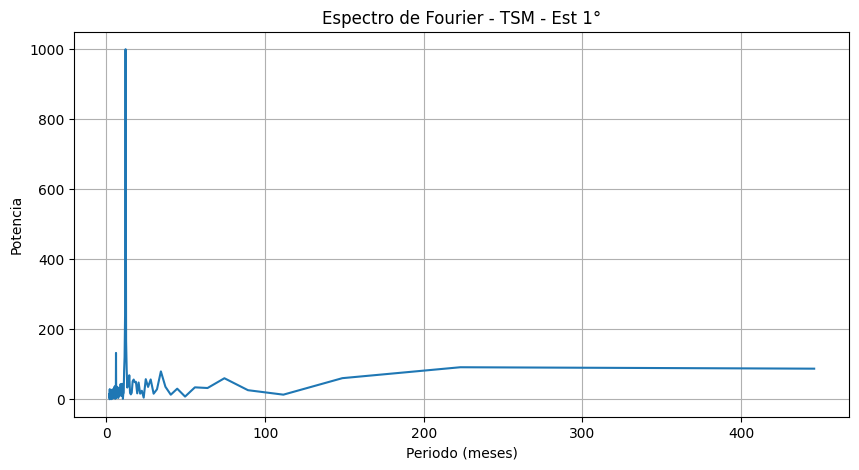

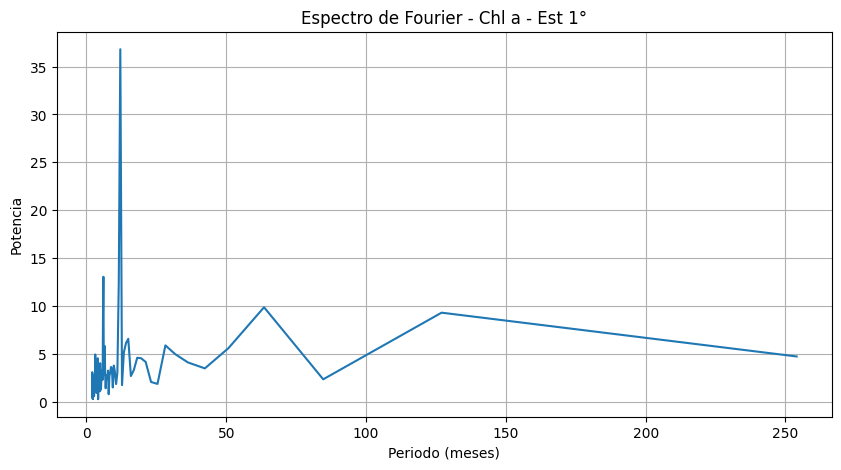

C:\Users\angel\AppData\Local\Temp\ipykernel_972\678666401.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coefficients, frequencies = pywt.cwt(series.fillna(method='ffill'), scales, 'morl')


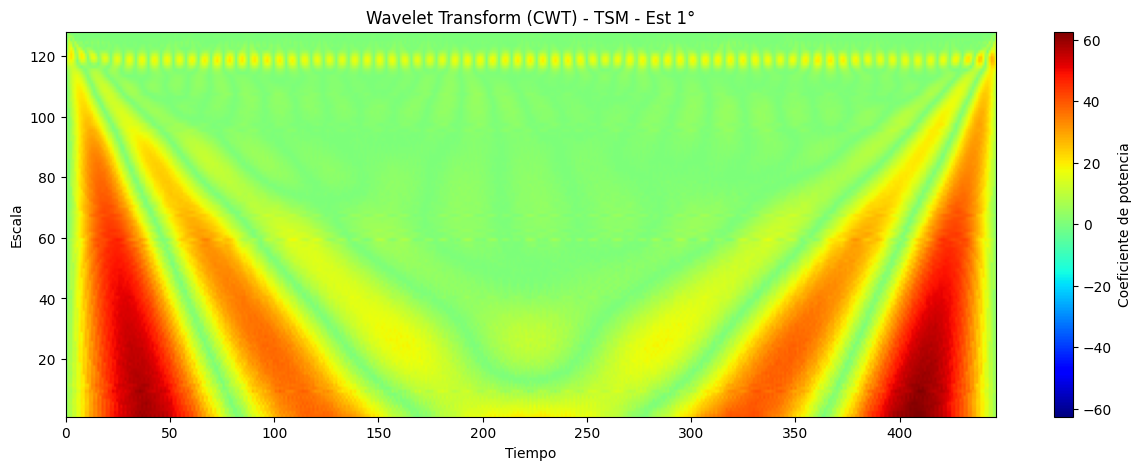

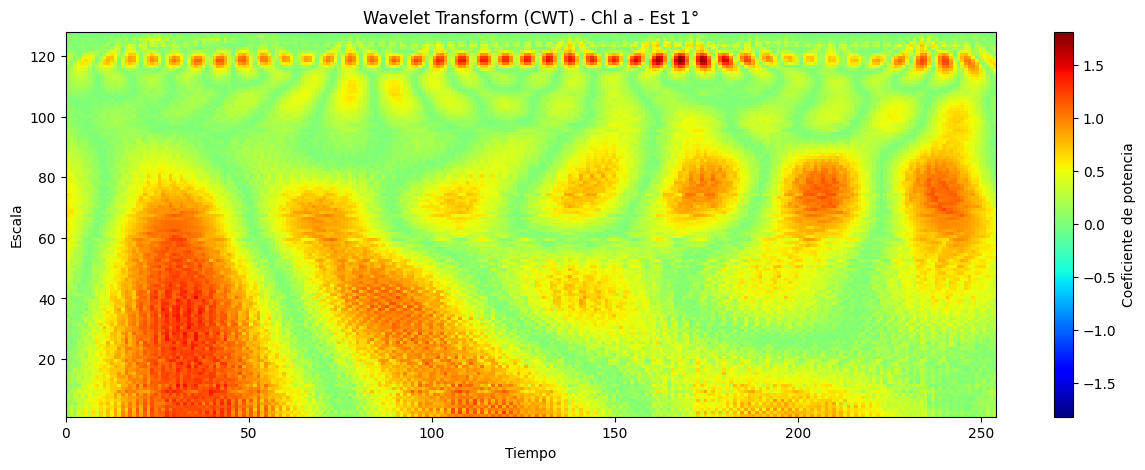

In [14]:
# Transformada rápida de Fourier
def fourier_analysis(series, title):
    y = series - series.mean()
    f = np.fft.fftfreq(len(y), d=1)  # Suponiendo mensual: d=1
    Y = np.fft.fft(y)
    plt.figure(figsize=(10,5))
    plt.plot(1/abs(f[1:len(f)//2]), abs(Y[1:len(Y)//2]))
    plt.title(f'Espectro de Fourier - {title}')
    plt.xlabel('Periodo (meses)')
    plt.ylabel('Potencia')
    plt.grid()
    plt.show()

fourier_analysis(tsm[estacion], f'TSM - {estacion}')
fourier_analysis(chla[estacion], f'Chl a - {estacion}')

# Transformada Wavelet
def wavelet_analysis(series, title):
    scales = np.arange(1, 128)
    coefficients, frequencies = pywt.cwt(series.fillna(method='ffill'), scales, 'morl')
    plt.figure(figsize=(15,5))
    plt.imshow(abs(coefficients), extent=[0, len(series), 1, 128], cmap='jet', aspect='auto', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())
    plt.title(f'Wavelet Transform (CWT) - {title}')
    plt.xlabel('Tiempo')
    plt.ylabel('Escala')
    plt.colorbar(label='Coeficiente de potencia')
    plt.show()

wavelet_analysis(tsm[estacion], f'TSM - {estacion}')
wavelet_analysis(chla[estacion], f'Chl a - {estacion}')

In [16]:
# Descargar ONI
oni = pd.read_csv('https://psl.noaa.gov/enso/oni/oni.data', sep='\s+', skiprows=1, header=None, engine='python')
oni = oni.melt(id_vars=0)
oni.columns = ['Year', 'Month', 'ONI']
oni['FECHA'] = pd.to_datetime(oni['Year'].astype(str) + '-' + oni['Month'])
oni = oni[['FECHA', 'ONI']]

# Resamplear ONI a mensual (si no está mensual)
oni.set_index('FECHA', inplace=True)
oni = oni.resample('M').ffill()

# Merge TSM y ONI
data_merged = pd.merge(tsm[['FECHA', estacion]], oni, left_on='FECHA', right_index=True)

# Correlación
corr_tsm = data_merged[estacion].corr(data_merged['ONI'])
print(f"Correlación TSM-ONI: {corr_tsm:.2f}")

# Igual para Chla
data_merged_chla = pd.merge(chla[['FECHA', estacion]], oni, left_on='FECHA', right_index=True)
corr_chla = data_merged_chla[estacion].corr(data_merged_chla['ONI'])
print(f"Correlación Chl a-ONI: {corr_chla:.2f}")


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\angel\AppData\Local\Temp\ipykernel_972\3199279264.py:2: SyntaxWarning: invalid escape sequence '\s'
  oni = pd.read_csv('https://psl.noaa.gov/enso/oni/oni.data', sep='\s+', skiprows=1, header=None, engine='python')
C:\Users\angel\AppData\Local\Temp\ipykernel_972\3199279264.py:2: SyntaxWarning: invalid escape sequence '\s'
  oni = pd.read_csv('https://psl.noaa.gov/enso/oni/oni.data', sep='\s+', skiprows=1, header=None, engine='python')


HTTPError: HTTP Error 404: Not Found